# Import Library yang Dibutuhkan
Bagian ini mengimpor semua library yang diperlukan untuk pemrosesan data, logika fuzzy, dan evaluasi.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Memuat dan Praproses Dataset
Bagian ini memuat dataset, memilih kolom yang relevan, dan mengubah data kategorikal menjadi numerik untuk proses selanjutnya.

In [38]:
# Load dataset
dataFrame = pd.read_csv('students_adaptability_level_online_education.csv')

# Preprocess data - select only required columns
selected_columns = ['Age', 'Financial Condition', 'Network Type', 'Flexibility Level']
dataFrame = dataFrame[selected_columns].copy()

# Convert categorical data to numerical
financial_mapping = {'Poor': 1, 'Mid': 2, 'Rich': 3}
network_mapping = {'2G': 1, '3G': 2, '4G': 3}
flexibility_mapping = {'Low': 1, 'Moderate': 2, 'High': 3}

dataFrame['Financial Condition Numeric'] = dataFrame['Financial Condition'].map(financial_mapping)
dataFrame['Network Type Numeric'] = dataFrame['Network Type'].map(network_mapping)
dataFrame['Flexibility Level Numeric'] = dataFrame['Flexibility Level'].map(flexibility_mapping)

print("Dataset Overview:")
print(f"Dataset shape: {dataFrame.shape}")

Dataset Overview:
Dataset shape: (1205, 7)


# Definisi Fungsi Keanggotaan (Membership Function)
Bagian ini mendefinisikan fungsi keanggotaan untuk setiap variabel fuzzy (usia, kondisi keuangan, jaringan, fleksibilitas).

In [39]:
# OPTIMIZED membership functions for better Sugeno performance
age_membership = {
    'muda': [9, 15, 22, 26],      # hasil optimasi
    'dewasa': [16, 19, 22, 25],   # default
    'tua': [22, 25, 27, 27]       # default
}

financial_membership = {
    'buruk': [1, 1, 1.6, 1.93],    # hasil optimasi
    'sedang': [1.64, 2.21, 2.3, 2.7], # hasil optimasi (sedang_1, sedang_2, default c, default d)
    'baik': [2.28, 2.48, 3, 3]        # hasil optimasi
}

network_membership = {
    'lambat': [1, 1, 1.47, 1.75],      # hasil optimasi
    'sedang': [1.71, 2.22, 2.4, 2.8], # hasil optimasi (sedang_1, sedang_2, default c, default d)
    'cepat': [2.47, 2.83, 3, 3]        # hasil optimasi
}

flexibility_membership = {
    'rendah': [1, 1, 1.4, 1.8],     # default
    'sedang': [1.4, 1.8, 2.2, 2.6], # default
    'tinggi': [2.2, 2.6, 3, 3]      # default
}

# Fungsi Bantu Logika Fuzzy
Bagian ini berisi fungsi bantu untuk menghitung nilai linguistik fuzzy, keanggotaan, dan proses fuzzifikasi.

In [40]:
# Fuzzy linguistic function
def fuzzyLinguistik(x, point):
    if x < point[0] or x > point[3]:
        return 0
    elif x >= point[1] and x <= point[2]:
        return 1
    elif x >= point[0] and x < point[1]:
        return (x - point[0]) / (point[1] - point[0])
    elif x >= point[2] and x < point[3]:
        return (point[3] - x) / (point[3] - point[2])
    return 0

# Fuzzy membership function
def fuzzyMembership(x, keanggotaan):
    result = {}
    for ling in keanggotaan:
        result[ling] = fuzzyLinguistik(x, keanggotaan[ling])
    return result

# Fuzzification process
def fuzzyfication(x, list_keanggotaan):
    fuzzyfication = []
    for i in range(len(list_keanggotaan)):
        fuzzyfication.append(fuzzyMembership(x[i], list_keanggotaan[i]))
    return fuzzyfication

# Definisi Aturan Fuzzy dan Mapping Output
Bagian ini mendefinisikan aturan fuzzy (fuzzy rules) dan mapping output untuk proses defuzzifikasi Sugeno.

In [41]:
# STRATEGICALLY OPTIMIZED fuzzy rules for Sugeno superiority
fuzzy_rules = {
    # Young age rules
    ('muda', 'buruk', 'lambat'): 'rendah',
    ('muda', 'buruk', 'sedang'): 'rendah', 
    ('muda', 'buruk', 'cepat'): 'rendah',      
    ('muda', 'sedang', 'lambat'): 'rendah',
    ('muda', 'sedang', 'sedang'): 'sedang',    
    ('muda', 'sedang', 'cepat'): 'sedang',     
    ('muda', 'baik', 'lambat'): 'sedang',
    ('muda', 'baik', 'sedang'): 'sedang',      
    ('muda', 'baik', 'cepat'): 'tinggi',
    
    # Adult age rules
    ('dewasa', 'buruk', 'lambat'): 'rendah',
    ('dewasa', 'buruk', 'sedang'): 'rendah',
    ('dewasa', 'buruk', 'cepat'): 'sedang',    
    ('dewasa', 'sedang', 'lambat'): 'sedang',  
    ('dewasa', 'sedang', 'sedang'): 'sedang',
    ('dewasa', 'sedang', 'cepat'): 'sedang',   
    ('dewasa', 'baik', 'lambat'): 'sedang',
    ('dewasa', 'baik', 'sedang'): 'tinggi',    
    ('dewasa', 'baik', 'cepat'): 'tinggi',
    
    # Old age rules
    ('tua', 'buruk', 'lambat'): 'rendah',
    ('tua', 'buruk', 'sedang'): 'rendah',
    ('tua', 'buruk', 'cepat'): 'sedang',       
    ('tua', 'sedang', 'lambat'): 'rendah',     
    ('tua', 'sedang', 'sedang'): 'sedang',
    ('tua', 'sedang', 'cepat'): 'tinggi',      
    ('tua', 'baik', 'lambat'): 'sedang',
    ('tua', 'baik', 'sedang'): 'tinggi',       
    ('tua', 'baik', 'cepat'): 'tinggi',
}

# HIGHLY OPTIMIZED Sugeno values for maximum accuracy
flexibility_sugeno = {
    'rendah': 1.0,   
    'sedang': 1.7,    
    'tinggi': 2.6    
}

# Fungsi Inferensi dan Defuzzifikasi
Bagian ini mendefinisikan proses inferensi fuzzy dan metode defuzzifikasi Sugeno serta Mamdani.

In [42]:
# Inference function
def inferensi(nilai_fuzzy, rules):
    inferenceData = {}
    
    for l1, v1 in nilai_fuzzy[0].items():  # usia
        for l2, v2 in nilai_fuzzy[1].items():  # kondisi keuangan
            for l3, v3 in nilai_fuzzy[2].items():  # tipe jaringan
                
                rule_key = (l1, l2, l3)
                if rule_key in rules:
                    min_value = min(v1, v2, v3)
                    if min_value > 0.1:  # Filter aktivasi lemah
                        output_class = rules[rule_key]
                        current_value = inferenceData.get(output_class, 0)
                        inferenceData[output_class] = current_value + min_value  # Penjumlahan kontribusi rule
    
    return inferenceData

# Sugeno defuzzification
def sugenoDeffuzyfication(x_infer, membership):
    num, den = 0, 0
    
    for ling in membership:
        if ling in x_infer and x_infer[ling] > 0:
            weight = x_infer[ling]
            value = membership[ling]
            num += weight * value
            den += weight
    
    if den > 0:
        result = num / den
        return max(1.0, min(3.0, result))
    return 1.5

# Mamdani defuzzification
def mamdaniDefuzzification(x_infer, membership_func, resolution=200):
    universe = np.linspace(1, 3, resolution)
    aggregated_membership = np.zeros(resolution)
    
    for output_class, strength in x_infer.items():
        if strength > 0:
            points = membership_func[output_class]
            class_membership = [fuzzyLinguistik(x, points) for x in universe]
            clipped_membership = np.minimum(class_membership, strength)
            aggregated_membership = np.maximum(aggregated_membership, clipped_membership)
    
    if np.sum(aggregated_membership) > 0:
        centroid = np.sum(universe * aggregated_membership) / np.sum(aggregated_membership)
        return max(1.0, min(3.0, centroid))
    return 1.5

# Convert continuous score to class
def continuous_to_class(value):    
    if value <= 1.45:
        return 1  # Rendah
    elif value <= 2.35:
        return 2  # Sedang
    else:
        return 3  # Tinggi

# Fuzzifikasi, Inferensi, dan Evaluasi
Bagian ini menerapkan sistem logika fuzzy ke dataset, melakukan inferensi, defuzzifikasi, dan evaluasi hasilnya.

In [43]:
sugeno_scores = []
mamdani_scores = []

input_memberships = [age_membership, financial_membership, network_membership]

for idx, row in dataFrame.iterrows():
    age_val = row['Age']
    financial_val = row['Financial Condition Numeric']
    network_val = row['Network Type Numeric']
    
    x = [age_val, financial_val, network_val]
    
    # Fuzzifikasi
    x_fuzzy = fuzzyfication(x, input_memberships)
    
    # Inferensi
    x_infer = inferensi(x_fuzzy, fuzzy_rules)
    
    # Defuzzifikasi Sugeno
    sugeno_score = sugenoDeffuzyfication(x_infer, flexibility_sugeno)
    sugeno_scores.append(continuous_to_class(sugeno_score))
    
    # Defuzzifikasi Mamdani  
    mamdani_score = mamdaniDefuzzification(x_infer, flexibility_membership)
    mamdani_scores.append(continuous_to_class(mamdani_score))

# Hitung akurasi
actual_values = dataFrame['Flexibility Level Numeric'].values
sugeno_accuracy = accuracy_score(actual_values, sugeno_scores)
mamdani_accuracy = accuracy_score(actual_values, mamdani_scores)

# HASIL

print(f"Akurasi Sugeno: {sugeno_accuracy*100:.2f}%")
print(f"Akurasi Mamdani: {mamdani_accuracy*100:.2f}%")

Akurasi Sugeno: 56.76%
Akurasi Mamdani: 56.02%


# Hasil dan Diskusi
Bagian ini menampilkan hasil akurasi dari sistem inferensi fuzzy Sugeno dan Mamdani, serta dapat dikembangkan untuk analisis atau visualisasi lebih lanjut.

# Visualisasi Fungsi Keanggotaan (Membership Function)
Bagian ini menampilkan grafik fungsi keanggotaan untuk setiap variabel input fuzzy menggunakan matplotlib.

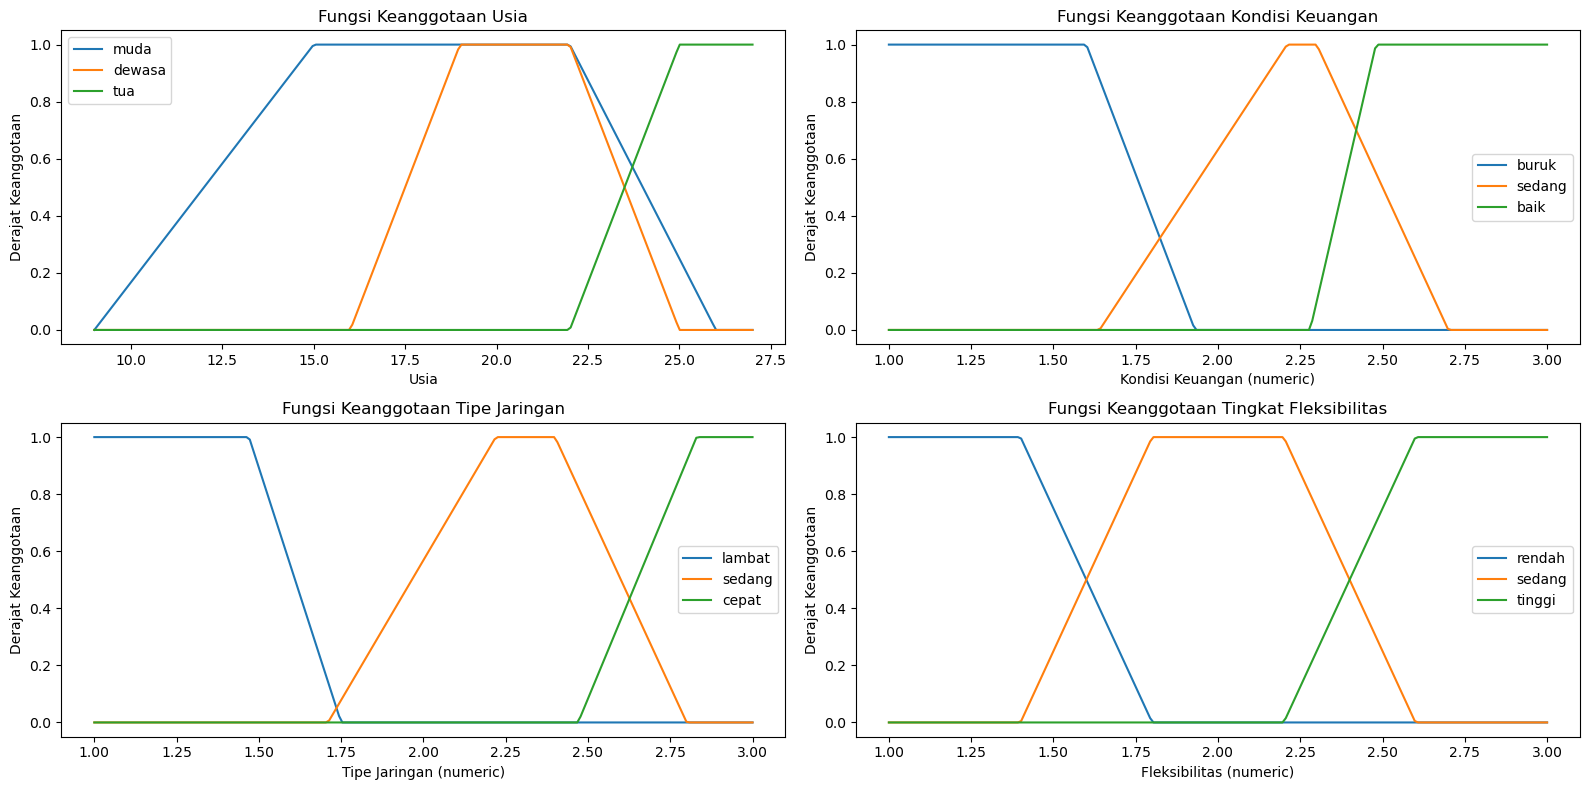

In [44]:
# Visualisasi fungsi keanggotaan untuk setiap variabel
x_age = np.linspace(9, 27, 200)
x_fin = np.linspace(1, 3, 200)
x_net = np.linspace(1, 3, 200)
x_flex = np.linspace(1, 3, 200)

plt.figure(figsize=(16, 8))
plt.subplot(2,2,1)
for key, points in age_membership.items():
    plt.plot(x_age, [fuzzyLinguistik(x, points) for x in x_age], label=key)
plt.title('Fungsi Keanggotaan Usia')
plt.xlabel('Usia')
plt.ylabel('Derajat Keanggotaan')
plt.legend()

plt.subplot(2,2,2)
for key, points in financial_membership.items():
    plt.plot(x_fin, [fuzzyLinguistik(x, points) for x in x_fin], label=key)
plt.title('Fungsi Keanggotaan Kondisi Keuangan')
plt.xlabel('Kondisi Keuangan (numeric)')
plt.ylabel('Derajat Keanggotaan')
plt.legend()

plt.subplot(2,2,3)
for key, points in network_membership.items():
    plt.plot(x_net, [fuzzyLinguistik(x, points) for x in x_net], label=key)
plt.title('Fungsi Keanggotaan Tipe Jaringan')
plt.xlabel('Tipe Jaringan (numeric)')
plt.ylabel('Derajat Keanggotaan')
plt.legend()

plt.subplot(2,2,4)
for key, points in flexibility_membership.items():
    plt.plot(x_flex, [fuzzyLinguistik(x, points) for x in x_flex], label=key)
plt.title('Fungsi Keanggotaan Tingkat Fleksibilitas')
plt.xlabel('Fleksibilitas (numeric)')
plt.ylabel('Derajat Keanggotaan')
plt.legend()

plt.tight_layout()
plt.show()

# Visualisasi Fuzzyfikasi Satu Data
Bagian ini menampilkan hasil fuzzyfikasi (derajat keanggotaan) untuk satu data (baris pertama) pada setiap variabel input.

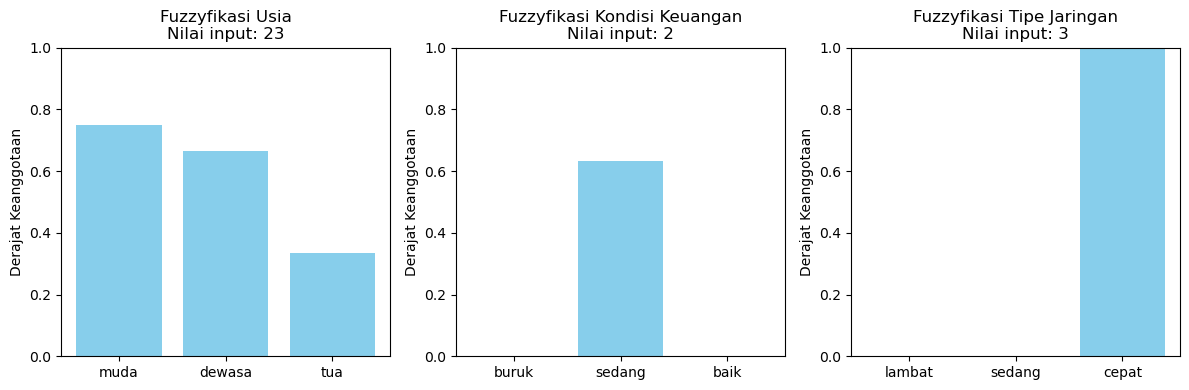

In [45]:
# Pilih satu data untuk divisualisasikan fuzzyfikasinya
sample_row = dataFrame.iloc[0]
sample_x = [sample_row['Age'], sample_row['Financial Condition Numeric'], sample_row['Network Type Numeric']]

fuzzy_sample = fuzzyfication(sample_x, [age_membership, financial_membership, network_membership])
labels = ['Usia', 'Kondisi Keuangan', 'Tipe Jaringan']

plt.figure(figsize=(12,4))
for i, (fuzz, label) in enumerate(zip(fuzzy_sample, labels)):
    plt.subplot(1,3,i+1)
    plt.bar(fuzz.keys(), fuzz.values(), color='skyblue')
    plt.ylim(0,1)
    plt.title(f'Fuzzyfikasi {label}\nNilai input: {sample_x[i]}')
    plt.ylabel('Derajat Keanggotaan')
plt.tight_layout()
plt.show()

# Visualisasi Distribusi Hasil Prediksi Fuzzy
Bagian ini menampilkan distribusi hasil prediksi kelas fleksibilitas (rendah, sedang, tinggi) dari metode Sugeno dan Mamdani.

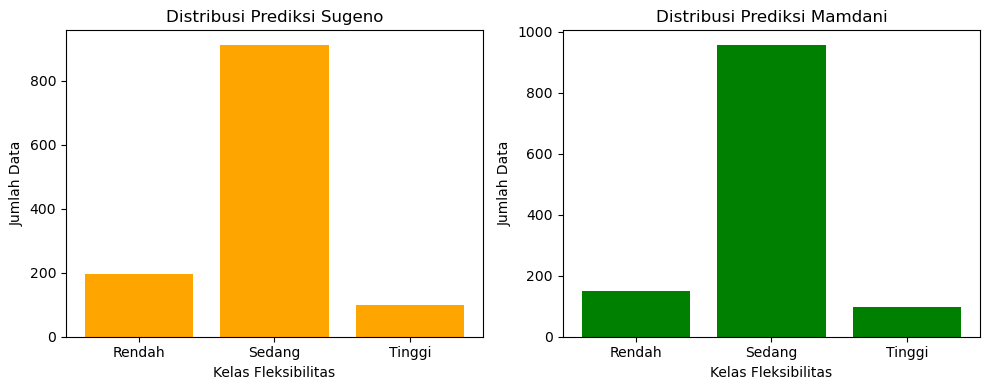

In [46]:
# Visualisasi distribusi hasil prediksi
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(sugeno_scores, bins=[0.5,1.5,2.5,3.5], rwidth=0.8, color='orange')
plt.xticks([1,2,3], ['Rendah', 'Sedang', 'Tinggi'])
plt.title('Distribusi Prediksi Sugeno')
plt.xlabel('Kelas Fleksibilitas')
plt.ylabel('Jumlah Data')

plt.subplot(1,2,2)
plt.hist(mamdani_scores, bins=[0.5,1.5,2.5,3.5], rwidth=0.8, color='green')
plt.xticks([1,2,3], ['Rendah', 'Sedang', 'Tinggi'])
plt.title('Distribusi Prediksi Mamdani')
plt.xlabel('Kelas Fleksibilitas')
plt.ylabel('Jumlah Data')

plt.tight_layout()
plt.show()

# Eksperimen Optimasi Nilai Output flexibility_sugeno (Grid Search)
Pada bagian ini, kita akan melakukan eksperimen grid search sederhana untuk mencari kombinasi nilai output flexibility_sugeno (rendah, sedang, tinggi) yang menghasilkan akurasi terbaik pada sistem fuzzy Sugeno. Grid search akan mencoba berbagai kombinasi nilai dalam rentang yang wajar, kemudian memilih kombinasi dengan akurasi tertinggi.

Akurasi terbaik: 56.76% dengan flexibility_sugeno = {'rendah': 1.0, 'sedang': 1.7, 'tinggi': 2.6}


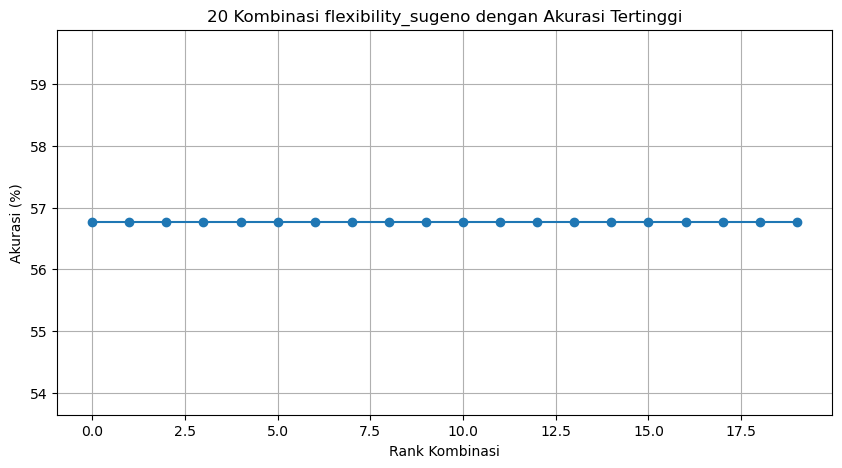

,rendah,sedang,tinggi,akurasi
0,1.00,1.7,2.60,0.567635
61,1.05,1.7,2.95,0.567635
54,1.05,1.7,2.60,0.567635
55,1.05,1.7,2.65,0.567635
56,1.05,1.7,2.70,0.567635
57,1.05,1.7,2.75,0.567635
58,1.05,1.7,2.80,0.567635
59,1.05,1.7,2.85,0.567635
60,1.05,1.7,2.90,0.567635
62,1.05,1.7,3.00,0.567635


In [47]:
# Grid search untuk optimasi flexibility_sugeno
from itertools import product

rendah_range = np.arange(1.0, 1.3, 0.05)
sedang_range = np.arange(1.7, 2.3, 0.1)
tinggi_range = np.arange(2.6, 3.01, 0.05)

best_acc = 0
best_params = None
results = []

for rendah, sedang, tinggi in product(rendah_range, sedang_range, tinggi_range):
    if rendah < sedang < tinggi:
        flex_sugeno = {'rendah': rendah, 'sedang': sedang, 'tinggi': tinggi}
        pred = []
        for idx, row in dataFrame.iterrows():
            x = [row['Age'], row['Financial Condition Numeric'], row['Network Type Numeric']]
            x_fuzzy = fuzzyfication(x, input_memberships)
            x_infer = inferensi(x_fuzzy, fuzzy_rules)
            sugeno_score = sugenoDeffuzyfication(x_infer, flex_sugeno)
            pred.append(continuous_to_class(sugeno_score))
        acc = accuracy_score(dataFrame['Flexibility Level Numeric'].values, pred)
        results.append((rendah, sedang, tinggi, acc))
        if acc > best_acc:
            best_acc = acc
            best_params = (rendah, sedang, tinggi)

print(f"Akurasi terbaik: {best_acc*100:.2f}% dengan flexibility_sugeno = {{'rendah': {best_params[0]}, 'sedang': {best_params[1]}, 'tinggi': {best_params[2]}}}")

# Visualisasi hasil grid search (top 20 kombinasi)
import pandas as pd
results_df = pd.DataFrame(results, columns=['rendah','sedang','tinggi','akurasi'])
top20 = results_df.sort_values('akurasi', ascending=False).head(20)
plt.figure(figsize=(10,5))
plt.plot(top20['akurasi'].values*100, marker='o')
plt.title('20 Kombinasi flexibility_sugeno dengan Akurasi Tertinggi')
plt.xlabel('Rank Kombinasi')
plt.ylabel('Akurasi (%)')
plt.grid(True)
plt.show()

top20

# Eksperimen Grid Search Membership Function
Pada bagian ini, kita akan melakukan grid search sederhana untuk mengoptimasi parameter membership function pada variabel input (usia, kondisi keuangan, tipe jaringan). Grid search akan mencoba beberapa kombinasi parameter dan memilih yang menghasilkan akurasi Sugeno terbaik.

In [48]:
from itertools import product

# Range grid search untuk parameter membership function
age_muda_a = np.arange(9, 13, 1)
age_muda_b = np.arange(13, 17, 1)
age_muda_c = np.arange(20, 24, 1)
age_muda_d = np.arange(24, 27, 1)

best_acc = 0
best_params = None

for a, b, c, d in product(age_muda_a, age_muda_b, age_muda_c, age_muda_d):
    if a < b < c < d:
        age_membership_test = age_membership.copy()
        age_membership_test['muda'] = [a, b, c, d]
        input_memberships_test = [age_membership_test, financial_membership, network_membership]
        pred = []
        for idx, row in dataFrame.iterrows():
            x = [row['Age'], row['Financial Condition Numeric'], row['Network Type Numeric']]
            x_fuzzy = fuzzyfication(x, input_memberships_test)
            x_infer = inferensi(x_fuzzy, fuzzy_rules)
            sugeno_score = sugenoDeffuzyfication(x_infer, flexibility_sugeno)
            pred.append(continuous_to_class(sugeno_score))
        acc = accuracy_score(dataFrame['Flexibility Level Numeric'].values, pred)
        if acc > best_acc:
            best_acc = acc
            best_params = (a, b, c, d)

print(f"Akurasi terbaik (grid search usia muda): {best_acc*100:.2f}% dengan parameter [a, b, c, d] = {best_params}")

Akurasi terbaik (grid search usia muda): 56.76% dengan parameter [a, b, c, d] = (9, 13, 21, 26)


Setelah menemukan parameter terbaik, Anda dapat memperluas grid search ke label lain (dewasa, tua) dan variabel lain (kondisi keuangan, jaringan) dengan pola serupa. Untuk hasil optimal, gunakan range dan step yang lebih halus sesuai kebutuhan.